In [1]:
import sys
import os
sys.path.append(os.path.abspath('../../'))

from rcgp.morcgp import MOGPRegressor, MORCGPRegressor, MOGPRegressor_NC, MORCGPRegressor_NC, MORCGPRegressor_NC_fixed_weights, MORCGPRegressor_fixed_weights, MORCGPRegressor_PM
from rcgp.rcgp import RCGPRegressor
from rcgp.kernels import ConstantMean, RBFKernel, SineMean
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.linalg import cholesky
from sklearn.covariance import MinCovDet

plt.rcParams.update({
    "text.usetex": True,         
    "font.family": "serif",       
    "text.latex.preamble": r"\usepackage{amsmath}",
    'font.size': 24,         
    'axes.labelsize': 24,    
    'xtick.labelsize': 24,   
    'ytick.labelsize': 24,  
    'legend.fontsize': 20,
    'lines.linewidth': 4,    
    'lines.markersize': 5   
})

In [2]:
def train_test_split_random(x, Y, N_train):
    total_samples = x.shape[0]
    all_indices = np.arange(total_samples)
    
    train_indices = np.random.choice(all_indices, size=N_train, replace=False)
    test_indices = np.setdiff1d(all_indices, train_indices)
    
    train_indices = np.sort(train_indices)
    test_indices = np.sort(test_indices)
    
    x_train = x[train_indices]
    Y_train = Y[train_indices]
    x_test = x[test_indices]
    Y_test = Y[test_indices]
    
    return x_train, Y_train, x_test, Y_test

def introduce_missing_values(Y, missing_percentage):
    num_elements = Y.size
    num_nan = int(missing_percentage * num_elements)

    nan_indices = np.random.choice(num_elements, num_nan, replace=False)

    Y_flat = Y.flatten().copy()

    Y_flat[nan_indices] = np.nan

    return Y_flat.reshape(Y.shape)

def rbf_kernel(x1, x2, lengthscale=1.0, variance=1.0):
    sqdist = np.sum(x1**2, 1).reshape(-1,1) + np.sum(x2**2,1) - 2*np.dot(x1, x2.T)
    return variance * np.exp(-0.5 / lengthscale**2 * sqdist)

def calculate_rmse(y_true, y_pred):
    errors = y_true - y_pred
    squared_errors = errors ** 2
    mse = np.mean(squared_errors)
    rmse = np.sqrt(mse)
    return rmse

def nlpd(Y_true, mu_pred, var_pred):
    epsilon = 1e-10
    var_pred = np.maximum(var_pred, epsilon)
    
    nlpd_values = 0.5 * np.log(2 * np.pi * var_pred) + ((Y_true - mu_pred) ** 2) / (2 * var_pred)
    
    return np.mean(nlpd_values)

# Outliers

In [7]:
rmses_mogp_outliers, rmses_morcgp_outliers, rmses_rcgp_outliers, rmses_pm_outliers = [], [], [], []
nlpds_mogp_outliers, nlpds_morcgp_outliers, nlpds_rcgp_outliers, nlpds_pm_outliers = [], [], [], []

train_test_N = 300
N, D = 100, 5
noise_var = 0.2
missing_percentage = 0.1 
epsilon = 0.1

lengthscale = 1.0
rbf_variance = 1.0

empty_noise = np.array([1e-6] * D)

B = np.array([
    [1.0,  0.9,  -0.7,  0.5,  -0.6],
    [0.9,  1.0,  -0.8,  0.6,  -0.7],
    [-0.7, -0.8,  1.0, -0.9,   0.8],
    [0.5,  0.6,  -0.9,  1.0,  -0.85],
    [-0.6, -0.7,  0.8, -0.85,  1.0]
])
A = np.linalg.cholesky(B)

for i in tqdm(range(20)):
    np.random.seed(i)
    x = np.sort(np.random.uniform(-5, 5, train_test_N)).reshape(-1, 1)
    Kx = rbf_kernel(x, x, lengthscale=lengthscale, variance=rbf_variance)
    K = np.kron(B, Kx)

    # Add a small jitter for numerical stability
    L = cholesky(K + 1e-6*np.eye(D*train_test_N), lower=True)

    f_samples = L @ np.random.randn(D*train_test_N)
    F = f_samples.reshape(D, train_test_N).T
    Y = F + np.random.normal(0, noise_var, F.shape)

    x_train, Y_train, x_test, Y_test = train_test_split_random(x, Y, N)
    Y_train = introduce_missing_values(Y_train, missing_percentage)

    # Add 5% outliers uniformly distributed in [-4, -2] ∪ [2, 4]
    num_outliers = int(epsilon * N * D * (1 - missing_percentage))
    # num_outliers = 0
    indices = np.unravel_index(np.random.choice(N * D, num_outliers, replace=False), (N, D))
    uniform_outliers = np.random.uniform(0, 1, num_outliers)
    outlier_values = np.where(
        uniform_outliers < 0.5,
        np.random.uniform(3, 5, num_outliers),
        np.random.uniform(-5, -3, num_outliers)
    )
    Y_train[indices] = outlier_values

    outliers_per_channel = np.bincount(indices[1])
    non_nan_counts = np.sum(~np.isnan(Y_train), axis=0)
    epsilons = outliers_per_channel / non_nan_counts

    # MOGP
    mogp = MOGPRegressor(mean=0, length_scale=1.0, noise = np.array([0.2] * D), A = 2*A)
    mogp.fit(x_train, Y_train)
    mogp.optimize_hyperparameters(print_opt_param=False, print_iter_param=False)
    optim_noise = mogp.noise
    optim_B = mogp.A @ mogp.A.T

    mu_mogp, var_mogp = mogp.predict(x_test)
    std_mogp = np.sqrt(var_mogp + mogp.noise)

    # MORCGP
    Y_train_clean = Y_train[~np.isnan(Y_train).any(axis=1)]
    mcd = MinCovDet(support_fraction=0.9).fit(Y_train_clean)
    robust_covariance = mcd.covariance_
    
    morcgp = MORCGPRegressor_fixed_weights(mean = 0, length_scale=lengthscale, noise = np.array([0.2]*D), A=A)
    initial_predictive_mean, initial_predictive_variances = morcgp.fit(x_train, Y_train, B_weighted=robust_covariance, noise_weighted=empty_noise)
    predictive_mean, predictive_variances = morcgp.optimize_loo_cv(weighted=True, print_opt_param = False, print_iter_param=False, update_weights=True)

    mu_morcgp, var_morcgp = morcgp.predict(x_test)
    std_morcgp = np.sqrt(var_morcgp + morcgp.noise)

    # MORCGP (RCGP weights)
    morcgp_pm = MORCGPRegressor_PM(mean=0, length_scale=lengthscale, noise=np.array([0.2]*D), A=A, epsilons=epsilons)
    morcgp_pm.fit(x_train, Y_train)
    morcgp_pm.optimize_loo_cv(weighted=True, print_opt_param = False, print_iter_param=False)

    mu_pm, var_pm = morcgp_pm.predict(x_test)
    std_pm = np.sqrt(var_pm + morcgp_pm.noise)

    # Performance metrics
    rmse_mogp = calculate_rmse(Y_test, mu_mogp)
    rmse_morcgp = calculate_rmse(Y_test, mu_morcgp)
    rmse_pm = calculate_rmse(Y_test, mu_pm)

    rmses_mogp_outliers.append(rmse_mogp)
    rmses_morcgp_outliers.append(rmse_morcgp)
    rmses_pm_outliers.append(rmse_pm)

    nlpd_mogp = nlpd(Y_test, mu_mogp, std_mogp**2)
    nlpd_morcgp = nlpd(Y_test, mu_morcgp, std_morcgp**2)
    nlpd_pm = nlpd(Y_test, mu_pm, std_pm**2)

    nlpds_mogp_outliers.append(nlpd_mogp)
    nlpds_morcgp_outliers.append(nlpd_morcgp)
    nlpds_pm_outliers.append(nlpd_pm)

print(f'RMSE MOGP: {np.mean(rmses_mogp_outliers):.4f} ± {np.std(rmses_mogp_outliers):.4f}')
print(f'RMSE MORCGP: {np.mean(rmses_morcgp_outliers):.4f} ± {np.std(rmses_morcgp_outliers):.4f}')
print(f'RMSE MORCGP (PM): {np.mean(rmses_pm_outliers):.4f} ± {np.std(rmses_pm_outliers):.4f}')

print(f'NLPD MOGP: {np.mean(nlpds_mogp_outliers):.4f} ± {np.std(nlpds_mogp_outliers):.4f}')
print(f'NLPD MORCGP: {np.mean(nlpds_morcgp_outliers):.4f} ± {np.std(nlpds_morcgp_outliers):.4f}')
print(f'NLPD MORCGP (PM): {np.mean(nlpds_pm_outliers):.4f} ± {np.std(nlpds_pm_outliers):.4f}')

100%|██████████| 20/20 [21:43<00:00, 65.20s/it]

RMSE MOGP: 0.4235 ± 0.0316
RMSE MORCGP: 0.2358 ± 0.0150
RMSE MORCGP (PM): 0.3148 ± 0.0281
NLPD MOGP: 1.2415 ± 0.0449
NLPD MORCGP: 0.3134 ± 0.0181
NLPD MORCGP (PM): 0.7847 ± 0.0958


# No outliers

In [48]:
rmses_mogp, rmses_morcgp, rmses_rcgp, rmses_pm = [], [], [], []
nlpds_mogp, nlpds_morcgp, nlpds_rcgp, nlpds_pm = [], [], [], []

train_test_N = 300
N, D = 100, 5
noise_var = 0.2
missing_percentage = 0
epsilon = 0.1

lengthscale = 1.0
rbf_variance = 2

prior_mean = ConstantMean(constant=0.0)

B = np.array([
    [1.0,  0.9,  -0.7,  0.5,  -0.6],
    [0.9,  1.0,  -0.8,  0.6,  -0.7],
    [-0.7, -0.8,  1.0, -0.9,   0.8],
    [0.5,  0.6,  -0.9,  1.0,  -0.85],
    [-0.6, -0.7,  0.8, -0.85,  1.0]
])
A = np.linalg.cholesky(B)

for i in tqdm(range(5)):
    np.random.seed(i)
    x = np.sort(np.random.uniform(-5, 5, train_test_N)).reshape(-1, 1)

    Kx = rbf_kernel(x, x, lengthscale=lengthscale, variance=rbf_variance)
    K = np.kron(B, Kx)
    L = cholesky(K + 1e-6*np.eye(D*train_test_N), lower=True)

    f_samples = L @ np.random.randn(D*train_test_N)
    F = f_samples.reshape(D, train_test_N).T
    Y = F + np.random.normal(0, noise_var, F.shape)
    Y -= np.mean(Y, axis=0)

    x_train, Y_train, x_test, Y_test = train_test_split_random(x, Y, N)
    Y_train = introduce_missing_values(Y_train, missing_percentage)

    # MOGP
    mogp = MOGPRegressor(mean=0, length_scale=1.0, noise = np.array([noise_var] * D), A = rbf_variance*A)
    mogp.fit(x_train, Y_train)
    mogp.optimize_hyperparameters(print_opt_param=False, print_iter_param=False)
    optim_noise = mogp.noise
    optim_B = mogp.A @ mogp.A.T

    mu_mogp, var_mogp = mogp.predict(x_test)
    std_mogp = np.sqrt(var_mogp + mogp.noise)

    # MORCGP
    # Y_train_clean = Y_train[~np.isnan(Y_train).any(axis=1)]
    mcd = MinCovDet(support_fraction=1.0).fit(Y_train)
    robust_covariance = mcd.covariance_
    
    morcgp = MORCGPRegressor_fixed_weights(mean = 0, length_scale=lengthscale, noise = np.array([noise_var]*D), A=rbf_variance*A)
    initial_predictive_mean, initial_predictive_variances = morcgp.fit(x_train, Y_train, B_weighted=robust_covariance, noise_weighted=empty_noise)
    predictive_mean, predictive_variances = morcgp.optimize_loo_cv(weighted=True, print_opt_param = False, print_iter_param=False, update_weights=True)

    mu_morcgp, var_morcgp = morcgp.predict(x_test)
    std_morcgp = np.sqrt(var_morcgp + morcgp.noise)

    # MORCGP (RCGP weights)
    morcgp_pm = MORCGPRegressor_PM(mean=0, length_scale=lengthscale, noise=np.array([noise_var]*D), A=rbf_variance*A, epsilons=[0]*D)
    morcgp_pm.fit(x_train, Y_train)
    morcgp_pm.optimize_loo_cv(weighted=True, print_opt_param = False, print_iter_param=False)

    mu_pm, var_pm = morcgp_pm.predict(x_test)
    std_pm = np.sqrt(var_pm + morcgp_pm.noise)

    rmse_mogp = calculate_rmse(Y_test, mu_mogp)
    rmse_morcgp = calculate_rmse(Y_test, mu_morcgp)
    rmse_pm = calculate_rmse(Y_test, mu_pm)

    rmses_mogp.append(rmse_mogp)
    rmses_morcgp.append(rmse_morcgp)
    rmses_pm.append(rmse_pm)

    nlpd_mogp = nlpd(Y_test, mu_mogp, std_mogp**2)
    nlpd_morcgp = nlpd(Y_test, mu_morcgp, std_morcgp**2)
    nlpd_pm = nlpd(Y_test, mu_pm, std_pm**2)

    nlpds_mogp.append(nlpd_mogp)
    nlpds_morcgp.append(nlpd_morcgp)
    nlpds_pm.append(nlpd_pm)

print(f'RMSE MOGP: {np.mean(rmses_mogp):.4f} ± {np.std(rmses_mogp):.4f}')
print(f'RMSE MORCGP: {np.mean(rmses_morcgp):.4f} ± {np.std(rmses_morcgp):.4f}')
print(f'RMSE MORCGP (PM): {np.mean(rmses_pm):.4f} ± {np.std(rmses_pm):.4f}')

print(f'NLPD MOGP: {np.mean(nlpds_mogp):.4f} ± {np.std(nlpds_mogp):.4f}')
print(f'NLPD MORCGP: {np.mean(nlpds_morcgp):.4f} ± {np.std(nlpds_morcgp):.4f}')
print(f'NLPD MORCGP (PM): {np.mean(nlpds_pm):.4f} ± {np.std(nlpds_pm):.4f}')

100%|██████████| 5/5 [09:15<00:00, 111.17s/it]

RMSE MOGP: 0.2116 ± 0.0059
RMSE MORCGP: 0.2271 ± 0.0058
RMSE MORCGP (PM): 0.2102 ± 0.0067
NLPD MOGP: -0.1276 ± 0.0260
NLPD MORCGP: 0.2662 ± 0.0073
NLPD MORCGP (PM): -0.1342 ± 0.0294


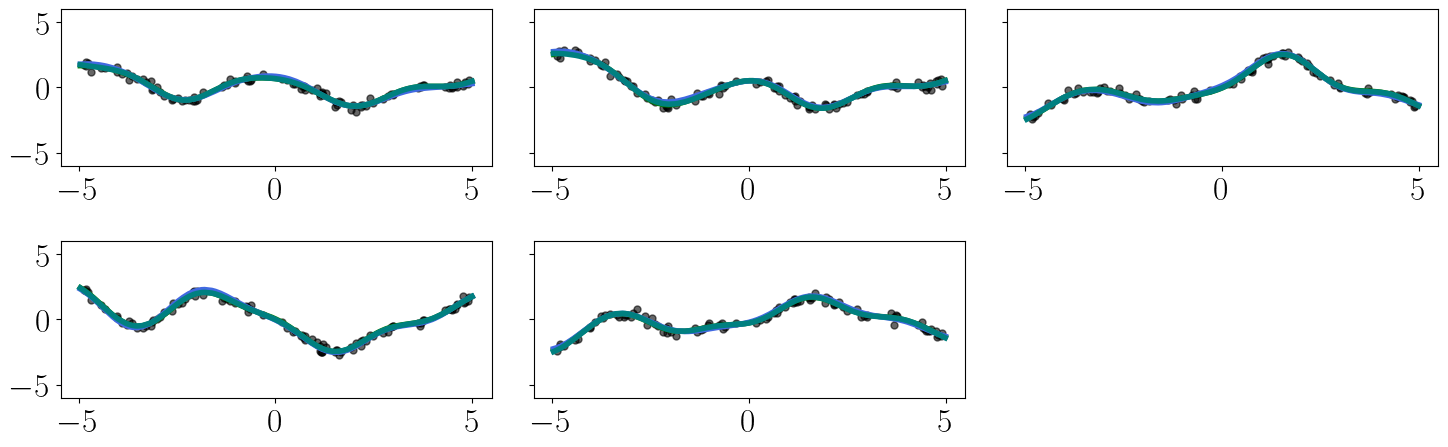

In [43]:
# Plotting
fig, axs = plt.subplots(2, 3, figsize=(15, 5))

for i in range(D):
    ax = axs[i // 3, i % 3]
    x_all = x_train.flatten()
    y_all = Y_train[:, i]

    ax.plot(x_all, y_all, 'o', color='black', alpha=0.6, label=f'Output {i+1} - inliers')
    # ax.plot(x_all, y_all, 'o', color='red', alpha=0.8, label='Outliers')

    # MOGP
    ax.plot(x_test.flatten(), mu_mogp[:, i], '-', color='Green', label=f'Predicted Mean')
    # ax.fill_between(x_test.flatten(), mu_mogp[:, i] - 2*std_mogp[:, i], mu_mogp[:, i] + 2*std_mogp[:, i], color='Blue', alpha=0.2, label=f'±2 Std. Dev.')

    # MORCGP
    ax.plot(x_test.flatten(), mu_morcgp[:, i], '-', color='RoyalBlue', label=f'Predicted Mean')
    # ax.fill_between(x_test.flatten(), mu_morcgp[:, i] - 2*std_morcgp[:, i], mu_morcgp[:, i] + 2*std_morcgp[:, i], color='Green', alpha=0.2, label=f'±2 Std. Dev.')

    # Predictive mean and variance
    # ax.plot(x_train.flatten(), predictive_mean[:, i], '-', color='red', label=f'Predictive Mean')
    # ax.fill_between(x_train.flatten(), predictive_mean[:, i] - np.sqrt(predictive_variances)[:, i], predictive_mean[:, i] + np.sqrt(predictive_variances)[:, i], color='red', alpha=0.2, label=f'±2 Std. Dev.')

    # ax.plot(x_train.flatten(), initial_predictive_mean[:, i], '-', color='green', label=f'Predictive Mean')
    # ax.fill_between(x_train.flatten(), initial_predictive_mean[:, i] - np.sqrt(initial_predictive_variances)[:, i], initial_predictive_mean[:, i] + np.sqrt(initial_predictive_variances)[:, i], color='green', alpha=0.2, label=f'±2 Std. Dev.')

    # # RCGP
    # ax.plot(x_test.flatten(), mu_rcgp[:, i], '-', color='Orange', label=f'Predicted Mean')
    # # ax.fill_between(x_test.flatten(), mu_rcgp[:, i] - 2*std_rcgp[:, i], mu_rcgp[:, i] + 2*std_rcgp[:, i], color='Red', alpha=0.2, label=f'±2 Std. Dev.')

    # MORCGP (RCGP weights)
    ax.plot(x_test.flatten(), mu_pm[:, i], '-', color='Teal', label=f'Predicted Mean')
    # ax.fill_between(x_test.flatten(), mu_pm[:, i] - 2*std_pm[:, i], mu_pm[:, i] + 2*std_pm[:, i], color='Teal', alpha=0.2, label=f'±2 Std. Dev.')

    ax.set_ylim([-6, 6])
    if i % 3 != 0:
        ax.set_yticklabels([])

# Hide the unused 6th subplot
axs[1, 2].axis('off')

plt.tight_layout()
plt.show()

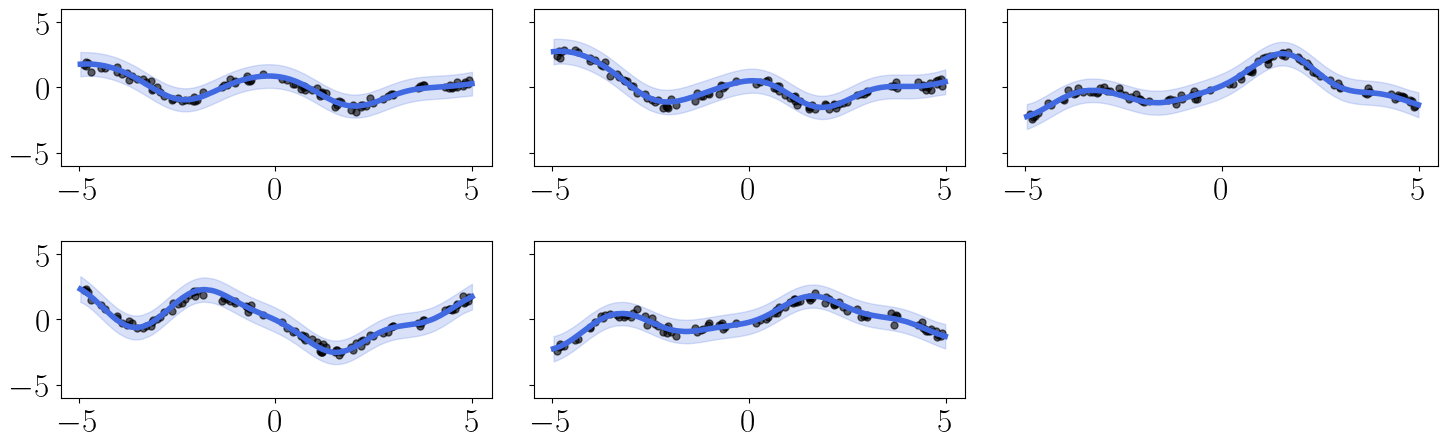

In [44]:
# Plotting
fig, axs = plt.subplots(2, 3, figsize=(15, 5))

for i in range(D):
    ax = axs[i // 3, i % 3]
    x_all = x_train.flatten()
    y_all = Y_train[:, i]

    ax.plot(x_all, y_all, 'o', color='black', alpha=0.6, label=f'Output {i+1} - inliers')
    # ax.plot(x_all, y_all, 'o', color='red', alpha=0.8, label='Outliers')

    # # MOGP
    # ax.plot(x_test.flatten(), mu_mogp[:, i], '-', color='Green', label=f'Predicted Mean')
    # ax.fill_between(x_test.flatten(), mu_mogp[:, i] - 2*std_mogp[:, i], mu_mogp[:, i] + 2*std_mogp[:, i], color='Blue', alpha=0.2, label=f'±2 Std. Dev.')

    # MORCGP
    ax.plot(x_test.flatten(), mu_morcgp[:, i], '-', color='RoyalBlue', label=f'Predicted Mean')
    ax.fill_between(x_test.flatten(), mu_morcgp[:, i] - 2*std_morcgp[:, i], mu_morcgp[:, i] + 2*std_morcgp[:, i], color='RoyalBlue', alpha=0.2, label=f'±2 Std. Dev.')

    # Predictive mean and variance
    # ax.plot(x_train.flatten(), predictive_mean[:, i], '-', color='red', label=f'Predictive Mean')
    # ax.fill_between(x_train.flatten(), predictive_mean[:, i] - np.sqrt(predictive_variances)[:, i], predictive_mean[:, i] + np.sqrt(predictive_variances)[:, i], color='red', alpha=0.2, label=f'±2 Std. Dev.')

    # ax.plot(x_train.flatten(), initial_predictive_mean[:, i], '-', color='green', label=f'Predictive Mean')
    # ax.fill_between(x_train.flatten(), initial_predictive_mean[:, i] - np.sqrt(initial_predictive_variances)[:, i], initial_predictive_mean[:, i] + np.sqrt(initial_predictive_variances)[:, i], color='green', alpha=0.2, label=f'±2 Std. Dev.')

    # # RCGP
    # ax.plot(x_test.flatten(), mu_rcgp[:, i], '-', color='Orange', label=f'Predicted Mean')
    # # ax.fill_between(x_test.flatten(), mu_rcgp[:, i] - 2*std_rcgp[:, i], mu_rcgp[:, i] + 2*std_rcgp[:, i], color='Red', alpha=0.2, label=f'±2 Std. Dev.')

    # MORCGP (RCGP weights)
    # ax.plot(x_test.flatten(), mu_pm[:, i], '-', color='Teal', label=f'Predicted Mean')
    # ax.fill_between(x_test.flatten(), mu_pm[:, i] - 2*std_pm[:, i], mu_pm[:, i] + 2*std_pm[:, i], color='Teal', alpha=0.2, label=f'±2 Std. Dev.')

    ax.set_ylim([-6, 6])
    if i % 3 != 0:
        ax.set_yticklabels([])

# Hide the unused 6th subplot
axs[1, 2].axis('off')

plt.tight_layout()
plt.show()

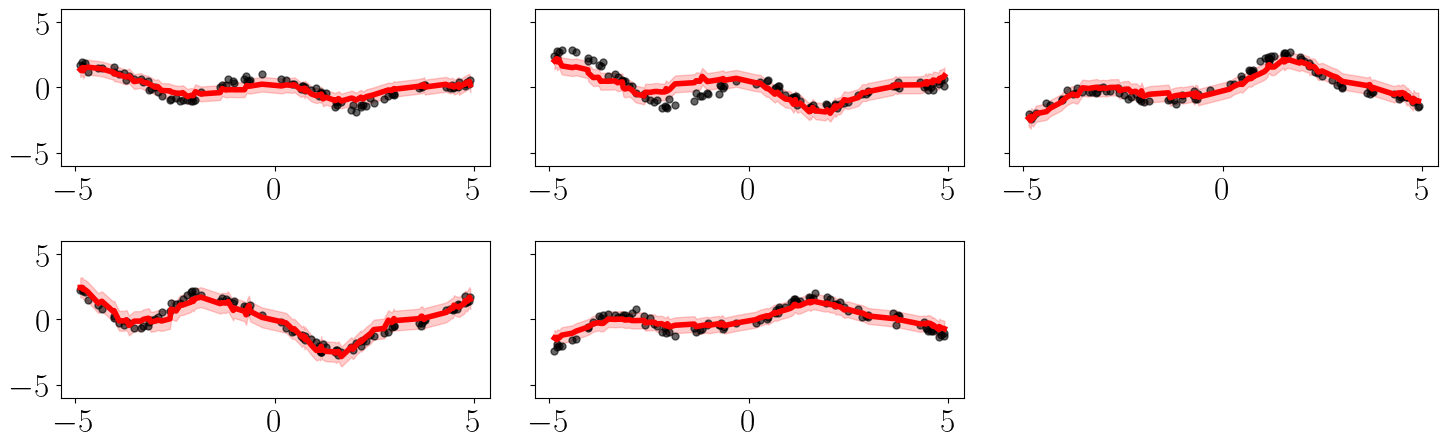

In [45]:
# Plotting
fig, axs = plt.subplots(2, 3, figsize=(15, 5))

for i in range(D):
    ax = axs[i // 3, i % 3]
    x_all = x_train.flatten()
    y_all = Y_train[:, i]

    ax.plot(x_all, y_all, 'o', color='black', alpha=0.6, label=f'Output {i+1} - inliers')
    # ax.plot(x_all, y_all, 'o', color='red', alpha=0.8, label='Outliers')

    # # MOGP
    # ax.plot(x_test.flatten(), mu_mogp[:, i], '-', color='Green', label=f'Predicted Mean')
    # ax.fill_between(x_test.flatten(), mu_mogp[:, i] - 2*std_mogp[:, i], mu_mogp[:, i] + 2*std_mogp[:, i], color='Blue', alpha=0.2, label=f'±2 Std. Dev.')

    # # MORCGP
    # ax.plot(x_test.flatten(), mu_morcgp[:, i], '-', color='RoyalBlue', label=f'Predicted Mean')
    # ax.fill_between(x_test.flatten(), mu_morcgp[:, i] - 2*std_morcgp[:, i], mu_morcgp[:, i] + 2*std_morcgp[:, i], color='RoyalBlue', alpha=0.2, label=f'±2 Std. Dev.')

    # Predictive mean and variance
    ax.plot(x_train.flatten(), predictive_mean[:, i], '-', color='red', label=f'Predictive Mean')
    ax.fill_between(x_train.flatten(), predictive_mean[:, i] - np.sqrt(predictive_variances)[:, i], predictive_mean[:, i] + np.sqrt(predictive_variances)[:, i], color='red', alpha=0.2, label=f'±2 Std. Dev.')

    # ax.plot(x_train.flatten(), initial_predictive_mean[:, i], '-', color='green', label=f'Predictive Mean')
    # ax.fill_between(x_train.flatten(), initial_predictive_mean[:, i] - np.sqrt(initial_predictive_variances)[:, i], initial_predictive_mean[:, i] + np.sqrt(initial_predictive_variances)[:, i], color='green', alpha=0.2, label=f'±2 Std. Dev.')

    # # RCGP
    # ax.plot(x_test.flatten(), mu_rcgp[:, i], '-', color='Orange', label=f'Predicted Mean')
    # # ax.fill_between(x_test.flatten(), mu_rcgp[:, i] - 2*std_rcgp[:, i], mu_rcgp[:, i] + 2*std_rcgp[:, i], color='Red', alpha=0.2, label=f'±2 Std. Dev.')

    # MORCGP (RCGP weights)
    # ax.plot(x_test.flatten(), mu_pm[:, i], '-', color='Teal', label=f'Predicted Mean')
    # ax.fill_between(x_test.flatten(), mu_pm[:, i] - 2*std_pm[:, i], mu_pm[:, i] + 2*std_pm[:, i], color='Teal', alpha=0.2, label=f'±2 Std. Dev.')

    ax.set_ylim([-6, 6])
    if i % 3 != 0:
        ax.set_yticklabels([])

# Hide the unused 6th subplot
axs[1, 2].axis('off')

plt.tight_layout()
plt.show()

In [46]:
print(optim_B + optim_noise*np.eye(D))
print(robust_covariance)

[[ 0.96269643  1.0264676  -0.69087874  0.39644925 -0.46542265]
 [ 1.0264676   1.44069032 -0.91126786  0.54177618 -0.68375813]
 [-0.69087874 -0.91126786  1.62264739 -1.72223659  1.34023271]
 [ 0.39644925  0.54177618 -1.72223659  2.27904688 -1.6516352 ]
 [-0.46542265 -0.68375813  1.34023271 -1.6516352   1.3722007 ]]
[[ 0.7247318   0.87273502 -0.7126597   0.58694515 -0.56030438]
 [ 0.87273502  1.33839551 -0.89033028  0.61575838 -0.68110773]
 [-0.7126597  -0.89033028  1.70831125 -1.75870747  1.21578659]
 [ 0.58694515  0.61575838 -1.75870747  2.08750555 -1.33554361]
 [-0.56030438 -0.68110773  1.21578659 -1.33554361  0.99930174]]
